# Synchrtron Radiation without sampling in CRPRopa

##  Unsorted notes on a fast synch. module

### Analytic starting point

Schlickeiser Cosmic Ray Astrophysics equations 4.1.8, 4.1.12a) and 4.1.17a) for the emissivity in the non absorbing case

energy loss rate eq. 4.1.22

#### Notes:
To my knowledge an isotropic particle distribution is assumed throughout calculations in this section. This is **different** from what is done in CRPropa. Especially the angles $\theta_\mathrm{CRPropa}$ and $\Theta_\mathrm{ana}$ are differently defined. In CRPropa $\theta_\mathrm{CRPropa}$ the angle refers to the pitch angle, meaning the angle between momentum $\mathbf{p}$ and magnetic field $\mathbf{B}$. In contrast, $\Theta_\mathrm{ana}$ is the angle between the magnetic field $\mathbf{B}$ and the line-of-sight direction magnetic field $\mathbf{R}$.


### CRPropa-data
Some implementation (following equations from Jackson Electrodynamics) are implemented in cal_synchrotron.py in this repo. They can be used for comparison. Integral over $F(x) = x \int_x^\infty K_5/3(x) \mathrm{d}x$ is e.g. implemented.

### general idea
Instead of sampling the synchrotron photons directly store the emitted spectrum / emission coefficient or similar in each time step. Or store a some of these (than information on the geometry must be provided during run-time.)


#### Questions:
 * What resolution in $\nu$?
 * Same bins for all particles?
 * Precalculate some values and interpolate during runtime?
 * Storing them in each step or summing already during runtime?
 * Normalize but energy loss?


### Notes (15.02.2023)

#### High energy $\gamma$-rays
Photons with energies above the pair production threshold should be propagated individully. Otherwise an inclusion of the secondary products becomes complicated and would contradict the concept of CRPropa.

#### Diffusive particle transport
DiffusionSDE assumes an isotropic (in momentum space) particle distributions. This is the same assumption as for the analytical descriptions in Schlickeiser "Cosmic Ray Astrophysics". The advantage is that observables like emission direction etc. depend on less parameters. 

 * The synchrotron power $P_\nu(\nu, \Theta_\mathrm{ana}(\mathbf{R}, \mathbf{r}), \gamma_e)$ still depends on the electron's energy and it's position. The emission coefficients $\epsilon_I$ and Stokes parameter $I$ still require integration (summation) over energies and along the line of sight.
 * The energy loss rate has to adapted to the average (over pitch angle distribution) energy loss rate, e.g., eq. 4.1.22.

 #### Ballistic particle transport
 Here, things are in general more complicated. As the energy loss depends in each step on the pitch angle of the particle. This in itself is not too bad, but also emission directions, etc. are changing with each step. This will make an approach to create maps very hard if not computationally impossible. An attempt to store the total synchrotron emissivity and an averaged spectrum might still be possible.


### Precalculated data from CRPropa-data

$x = E_\gamma / E_\mathrm{critical}$ with $E_\mathrm{critical} = \frac{3\hbar}{2}\,\frac{c}{r_\mathrm{g}} \cdot \left(\frac{E}{m_\mathrm{e}c^2}\right)^3$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import kv

from units import radius_electron, mass_electron, c_light, cm, second, eplus

In [2]:
synchdata = pd.read_csv('./data/Synchrotron/spectrum.txt', comment='#', delimiter='\t', names=['log10x', 'CDF'])

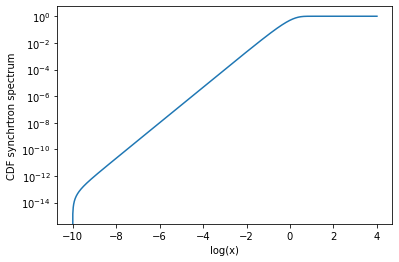

In [3]:
plt.figure()

plt.plot(synchdata.log10x, synchdata.CDF)
plt.xlabel('log(x)')
plt.ylabel('CDF synchrtron spectrum')
plt.semilogy()
plt.show()

## Reimplementation of CRPropa-data

This reimplementation is done for testing purposes. Furthermore, a function for the pdf in addition to the cdf was added.

In [13]:
def synchrotron_spectrum_cdf(xval):
    """
    Calculate cumulative synchrotron spectrum.
    Follows:
      J.~D. Jackson, Classical Electrondynamics.
      Wiley, 3rd ed., p. 681, eq. 14.91

    F(x) = (\int_{x}^{\infinity} K_{5/3}(x') dx') 
    for x = E_gamma / E_critical, where E_critical = hbar * 3/2 * c/rho * (E/(mc**2))**3
    E_gamma : Energy of synchrotron photon
    E       : Energy of particle
    rho     : gyroradius of the thermal particles mc**2 / q / B

    Returns : 
      The cumulative synchrotron function
    """
    F = np.zeros(len(xval))
    for i, value in enumerate(xval):
        a = xval[i:]
        F[i] = integrate.trapz(x = a, y = kv(5. / 3., a))
    for i,value in enumerate(xval):
        b = integrate.cumtrapz(x = xval, y = xval * F, initial = 0)
    return b / b[-1]

def synchrotron_spectrum(xval):
    """
    Calculate cumulative synchrotron spectrum.
    Follows:
      J.~D. Jackson, Classical Electrondynamics.
      Wiley, 3rd ed., p. 681, eq. 14.91

    F(x) = (\int_{x}^{\infinity} K_{5/3}(x') dx') 
    for x = E_gamma / E_critical, where E_critical = hbar * 3/2 * c/rho * (E/(mc**2))**3
    E_gamma : Energy of synchrotron photon
    E       : Energy of particle
    rho     : gyroradius of the thermal particles mc**2 / q / B
    Returns : 
      The cumulative synchrotron function
    """
    F = np.zeros(len(xval))
    for i, value in enumerate(xval):
        a = xval[i:]
        F[i] = integrate.trapz(x = a, y = kv(5. / 3., a))
    return  xval * F

In [5]:
x = np.logspace(-3., 1, 1401)
y = synchrotron_spectrum_cdf(x)
y2 = synchrotron_spectrum(x)

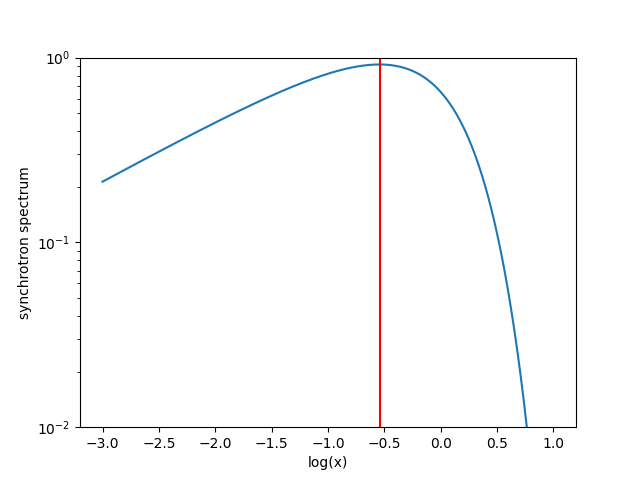

In [6]:
%matplotlib widget
plt.figure()

plt.plot(np.log10(x), y2, )
plt.vlines(np.log10(0.29), ymin=1e-3, ymax=1, colors='red')
plt.xlabel('log(x)')
plt.ylabel('synchrotron spectrum')
plt.ylim(1e-2, 1)
plt.semilogy()
plt.show()

## Implementation of Synchrotron radiation

The following functions implement equations from Schlickeiser's "Cosmic Ray Astrophysics". 

#### Note:
The cgs-unit system is used. 

In [7]:
from typing import List
Vector = List[float]


def P_synch(nu: Vector, theta: float, gamma_e: float, B: float) -> float:
    """Vacuum approximation of the total spontaneously emitted 
    synchrotron power.
    
    Following notion of Schlickeiser 2002 "Cosmic Ray Astophysics"

    Args:
        nu (Vector): frequency of emitted photons [Hz]
        theta (float): angle between magnetic field and line of sight of observer [rad]
        gamma_e (float): Lorentz factor of electrons
        B (float): magnetic field strength [gauss]

    Returns:
        float: Synchrotron power [erg s^-1 Hz^-1]
    """

    m = mass_electron / 1e-3 #[g]
    c = c_light / (cm*second**-1) #[cm s^-1]
    r0 = radius_electron / cm #[cm]
    sintheta = np.sin(theta)
    nu0 = gyro_frequency(B)
    nu_crit = critical_frequency(B, gamma_e)
    C = 2*np.pi*np.sqrt(3)*r0*m*c * nu0 * sintheta
    x = nu / nu_crit / sintheta
    
    return C * F(x)

def gyro_frequency(B: float) -> float:
    """Gyration frequency of thermal electrons

    Args:
        B (float): magnetic field strength [gauss]

    Returns:
        float: gyro frequency [Hz]
    """
    #e_cgs = eplus*c_light / cm
    #m = mass_electron / 1e-3
    # nu = (e_cgs * B) / (2*np.pi * m * c_light)
    #reduce cgs equation so save some computation time
    return  (eplus * B ) / (2*np.pi * mass_electron / 0.1)

def critical_frequency(B: float, gamma: float) -> float:
    """Critical frequency of synchrotron radiating electrons

    Args:
        B (float): magnetic field strength [gauss]
        gamma (float): Lorentz factor of relativistic electrons

    Returns:
        float: critical frequency
    """

    return 3./2. * gyro_frequency(B) * gamma**2.

def F(x: Vector) -> Vector:
    """Integral used in synchrotron radiation

    Args:
        x (Vector): nu / nu_crit / sin(theta)

    Returns:
        Vector: x * int_x^infty dt K_{5/3}(t) 
    """
    F = np.zeros(len(x))
    for i, x_ in enumerate(x):
        a = x[i:]
        F[i] = x_ * integrate.trapz(x = a, y = kv(5. / 3., a))
    return F

In [8]:
nu = np.logspace(-17, 25, 100)
gamma = 1e6
theta = np.pi/2.
B = 1e-6
P_1 = P_synch(nu, theta, gamma, B)
P_2 = P_synch(nu, theta/2., gamma, B)
P_3 = P_synch(nu, theta, gamma*100, B)

Text(0, 0.5, 'P_nu  [erg s^-1 Hz^-1]')

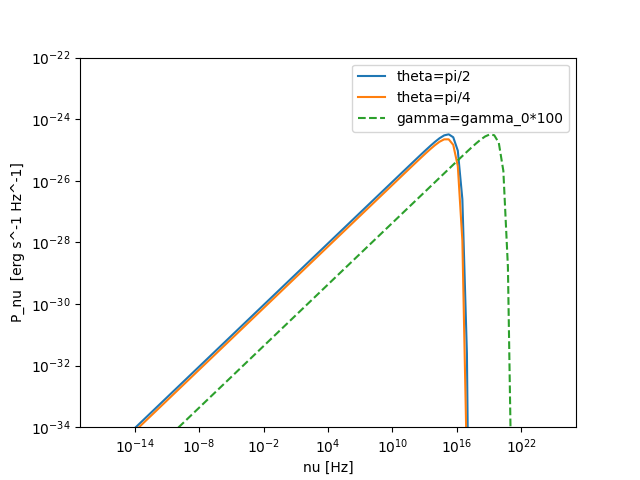

In [14]:
plt.figure()
plt.plot(nu, P_1, label="theta=pi/2")
plt.plot(nu, P_2, label="theta=pi/4")
plt.plot(nu, P_3, '--',  label="gamma=gamma_0*100")

plt.ylim(1e-34, 1e-22)
plt.loglog()

plt.legend()

plt.xlabel("nu [Hz]")
plt.ylabel("P_nu  [erg s^-1 Hz^-1]")